# Project 3: Reddit Natural Language Processing Classification
   ---
  *By Ethan Koh, 18 May 2020*

## Overview

Reddit <sup>1</sup> is a social news collection and discussion site founded in 2005 by two college friends: Steve Huffman and Alexis Ohanian. It has evolved to a home site for many growing communities, also know as subreddits. Within each subreddits, the registered member can create a post and share content such as text stories, links, images, and videos. The rest of the community can comment on posts as a means of discussion. Comments & posts can be upvoted or downvoted like a ranking. The most interesting content rises to the top. There is a large number of subreddits community that surrounds almost any topic of interest you can think of and find like-minded folks. It has been a place for people to seek advice, comfort, share knowledge or humour, and many more.

### Reddit Statistics:
*As of December 4, 2019*
- Average monthly active users: More than 430 Million
- Active communities: More than 130 Thousand
- Average screenviews per month: 21 Billion
- 5th Most visited site in US (on Alexa)

## Problem Set

Given a post, able to classify correctly whether it belongs to Parenting or CasualConversation subreddit. This is a binary classification problem. We will later label Parenting as 1 and CasualConversation as 0. The target audience are baby, toddlers or children retailers who keen on knowing the concerns of parents in order to have targetting marketing campaign to boost their sales revenue.


## Dataset

Dataset (from part1 notebook:Project_3_Reddit_API_to_CSV_Part_1.ipynb) is retrieved from r/CasualConversation <sup>2</sup> and r/Parenting <sup>3</sup> subreddits using the Reddit API on 14 May 2020.

## Contents:
- [Import Libraries](#Import-Libraries)
- [Load Dataset from CSV](#Load-Dataset-from-CSV)
- [Macro Analysis](#Macro-Analysis)
- [Data Cleaning](#Data-Cleaning)<ul>
- [Remove Null values](#Remove-Null-values)
- [Remove Duplicates](#Remove-Duplicates)</ul>
- [Choose stopwords library to use](#Choose-stopwords-library-to-use)<ul>
- [Number of words in total for each subreddit preprocessing](#Number-of-words-in-total-for-each-subreddit-preprocessing)
- [Calculate and Plot Word Frequency](#Calculate-and-Plot-Word-Frequency)
- [Create final stopwords](#Create-final-stopwords)</ul>
- [Combine into `X` and `y`](#Combine-into-X-and-y)
- [Split data into training and testing sets](#Split-data-into-training-and-testing-sets)
- [Words Preprocessing](#Words-Preprocessing)
- [Turn text into features](#Turn-text-into-features)
- [Baseline accuracy](#Baseline-accuracy)
- [Fit a Naive Bayes model](#Fit-a-Naive-Bayes-model)
- [Fit a Logistic Regression model](#Fit-a-Logistic-Regression-model)
- [Fit Random Forest Classifier](#Fit-Random-Forest-Classifier)
- [Compare a few models and get best score](#Compare-a-few-models-and-get-best-score)
- [Fine tuning Logistic Regression hyperparameters](#Fine-tuning-Logistic-Regression-hyperparameters)
- [Fit Final Logistic Model](#Fit-Final-Logistic-Model)
- [Conclusion](#Conclusion)
- [Limitations and Recommendation](#Limitations-and-Recommendation)
- [Sources](#Sources)

## Import Libraries

In [1]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup           
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import collections
import itertools
import pandas as pd
import re
import math
import numpy as np

## Load Dataset from CSV

In [2]:
casualconv = pd.read_csv('../data/CasualConversation.csv')
parenting = pd.read_csv('../data/Parenting.csv')

## Macro Analysis

In [3]:
#set option to view all columns
pd.set_option('display.max_columns', 100)
casualconv.head(3)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,collections,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,...,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,poll_data,author_cakeday
0,NaN,CasualConversation,"^(May, 2020)\n\nMonthly Meta is back - [follow...",t2_5r8xp,False,NaN,0,False,May Monthly Meta - r/CasualConversation Firesi...,"[{'a': ':shield:', 'e': 'emoji', 'u': 'https:/...",r/CasualConversation,[{'permalink': 'https://www.reddit.com/r/Casua...,False,6,NaN,0,False,t3_gbildz,False,light,0.80,#1a2e39,public,15,0,{},de7686a0-5b28-11ea-bb5b-0e4a07278bdd,False,[],NaN,False,False,NaN,{},:shield: Mod Post,False,15,NaN,True,NaN,False,tiz,"[{'a': ':cc:', 'e': 'emoji', 'u': 'https://emo...",{},NaN,True,NaN,1.588370e+09,richtext,6,...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,09a40b74-08ad-11e4-bc30-12313d224df5,False,False,False,:cc: I made this subreddit,[],False,NaN,NaN,moderator,t5_323oy,NaN,NaN,#4fc761,gbildz,True,NaN,tizorres,NaN,6,False,all_ads,False,[],False,light,/r/CasualConversation/comments/gbildz/may_mont...,all_ads,True,https://www.reddit.com/r/CasualConversation/co...,1220711,1.588342e+09,0,NaN,False,NaN,NaN
1,NaN,CasualConversation,Each day this week we'll poll you on how your...,t2_5r8xp,False,NaN,0,False,"Chat &amp; rate your day out of 5 - Tuesday, M...","[{'a': ':chat:', 'e': 'emoji', 'u': 'https://e...",r/CasualConversation,[{'permalink': 'https://www.reddit.com/r/Casua...,False,6,NaN,0,False,t3_gifijq,False,light,1.00,#1a2e39,public,21,0,{},de7686a0-5b28-11ea-bb5b-0e4a07278bdd,False,[],NaN,False,False,NaN,{},:chat: Just Chatting,False,21,NaN,True,NaN,False,tiz,"[{'a': ':cc:', 'e': 'emoji', 'u': 'https://emo...",{},NaN,True,NaN,1.589333e+09,richtext,6,...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,new,NaN,NaN,False,False,False,False,False,[],[],False,58904be0-3089-11e9-b6c6-0e12b0807136,False,False,False,:cc: I made this subreddit,[],False,NaN,NaN,moderator,t5_323oy,NaN,NaN,#638be4,gifijq,True,NaN,tizorres,CHAT,2679,False,all_ads,False,[],False,light,/r/CasualConversation/comments/gifijq/chat_rat...,all_ads,True,https://www.reddit.com/r/CasualConversation/co...,1220711,1.589304e+09,0,NaN,False,"{'user_selection': None, 'options': [{'text': ...",NaN
2,NaN,CasualConversation,I denied myself an Oreo and have only eaten to...,t2_3aam915h,False,NaN,1,False,"I don't think anybody cares much, but I'm proud.",[],r/CasualConversation,NaN,False,6,NaN,0,False,t3_gideyr,False,dark,0.94,NaN,public,8464,3,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,8464,NaN,True,NaN,1589297672.0,NaN,[],{'gid_2': 1},NaN,True,NaN,1.589326e+09,text,6,...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,NaN,False,False,False,NaN,[]

In [4]:
parenting.head(3)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,...,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,Parenting,"I get it, you're probably tired of hearing fro...",t2_7t43eqf,False,NaN,0,False,✨🤪Who's Got Cabin Fever?🏠😳,"[{'e': 'text', 't': 'Admin Post'}]",r/Parenting,False,6,admin,0,False,t3_g7hsl6,False,dark,0.98,NaN,public,59,0,{},NaN,False,[],NaN,False,False,NaN,{},Admin Post,False,59,NaN,True,NaN,False,NaN,"[{'e': 'text', 't': 'Lotsa bodies in this hous...",{},NaN,True,NaN,1.587795e+09,richtext,6,NaN,...,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,ff75b2ba-8561-11e9-9ad6-0e6ac7c705dc,False,False,False,Lotsa bodies in this house.,[],False,NaN,NaN,moderator,t5_2qhn3,NaN,NaN,#94e044,g7hsl6,True,NaN,MableXeno,NaN,52,True,all_ads,False,[],False,dark,/r/Parenting/comments/g7hsl6/whos_got_cabin_fe...,all_ads,True,https://www.reddit.com/r/Parenting/comments/g7...,2136801,1.587766e+09,0,NaN,False,NaN
1,NaN,Parenting,A weekly thread to share stories that happened...,t2_6l4z3,False,NaN,0,False,"Weekly - Stories From The Weekend - May 11, 2020","[{'e': 'text', 't': 'Weekly'}]",r/Parenting,False,6,weekly,0,False,t3_ghrlbl,False,dark,1.00,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},Weekly,False,1,NaN,True,NaN,False,NaN,"[{'e': 'text', 't': 'AutoParent to everyone'}]",{},NaN,True,NaN,1.589245e+09,richtext,6,NaN,...,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,5811ba70-58f3-11e6-b3b1-0e72fec5cf25,False,False,False,AutoParent to everyone,[],False,NaN,NaN,moderator,t5_2qhn3,NaN,NaN,#94e044,ghrlbl,True,NaN,AutoModerator,NaN,0,False,all_ads,False,[],False,dark,/r/Parenting/comments/ghrlbl/weekly_stories_fr...,all_ads,True,https://www.reddit.com/r/Parenting/comments/gh...,2136801,1.589217e+09,0,NaN,False,NaN
2,NaN,Parenting,My daughter (10) came to me recently and told ...,t2_16t6502,False,NaN,0,False,I accidentally introduced my daughter to the h...,"[{'e': 'text', 't': 'Pets'}]",r/Parenting,False,6,pets,0,False,t3_giar8i,False,light,0.98,NaN,public,476,0,{},NaN,False,[],NaN,False,False,NaN,{},Pets,False,476,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589317e+09,richtext,6,NaN,...,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,31c0453a-58f3-11e6-803c-0e82fd5ff589,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qhn3,NaN,NaN,#ffb000,giar8i,True,NaN,saltyhumor,NaN,68,True,all_ads,False,[],False,NaN,/r/Parenting/comments/giar8i/i_accidentally_in...,all_ads,False,https://www.reddit.com/r/Parenting/comments/gi...,2136801,1.589288e+09,0,NaN,False,NaN


In [5]:
# check data shape
print(casualconv.shape)
parenting.shape
# casualconv have 2 more columns than parenting

(752, 105)


(752, 103)

In [6]:
# finding what are the different columns
diff = casualconv.columns.difference(parenting.columns)
diff

Index(['collections', 'poll_data'], dtype='object')

In [7]:
# taking a look at poll_data
casualconv[casualconv['poll_data'].notnull()]['poll_data'].head(2)

1     {'user_selection': None, 'options': [{'text': ...
34    {'user_selection': None, 'options': [{'text': ...
Name: poll_data, dtype: object

In [8]:
# taking a look at poll_data
casualconv[casualconv['collections'].notnull()]['collections']

0     [{'permalink': 'https://www.reddit.com/r/Casua...
1     [{'permalink': 'https://www.reddit.com/r/Casua...
34    [{'permalink': 'https://www.reddit.com/r/Casua...
Name: collections, dtype: object

In [9]:
# Compare selftext_html vs selftext
casualconv['selftext_html'][1]

'&lt;!-- SC_OFF --&gt;&lt;div class="md"&gt;&lt;p&gt;Each day this week we&amp;#39;ll poll you on how your day is/was going - feel free to submit your vote whenever you think is best.&lt;/p&gt;\n\n&lt;p&gt;&lt;strong&gt;Let us know more about your day and chat with us in the comments!&lt;/strong&gt;&lt;/p&gt;\n\n&lt;p&gt;&lt;em&gt;Get notified when the next post is live - click follow on the collection.&lt;/em&gt;&lt;/p&gt;\n\n&lt;p&gt;&lt;a href="https://www.reddit.com/poll/gifijq"&gt;View Poll&lt;/a&gt;&lt;/p&gt;\n&lt;/div&gt;&lt;!-- SC_ON --&gt;'

In [10]:
casualconv['selftext'][1]
# selftext_html contains more misc characters 
# hence using selftext as the content is right

" Each day this week we'll poll you on how your day is/was going - feel free to submit your vote whenever you think is best.\n\n**Let us know more about your day and chat with us in the comments!**\n\n*Get notified when the next post is live - click follow on the collection.*\n\n[View Poll](https://www.reddit.com/poll/gifijq)"

**There are other variables that may be contribute better classification such as title,num_comments (number of comments). But to make classification more challenging, I decide to simply look at 'selftext' which is the content of each subreddit post. Before that, let's do some data cleaning.**

## Data Cleaning

### Remove Null values

In [11]:
# Check for null values
print(casualconv['selftext'].isnull().sum())
parenting['selftext'].isnull().sum()
# null values due to pinned posts

2


0

In [12]:
casualconv[casualconv['selftext'].isnull()]

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,collections,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,...,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,poll_data,author_cakeday
140,NaN,CasualConversation,NaN,t2_1uts21wu,False,NaN,0,False,Hey! I'm new to Reddit!!!!!! Any advice?,[],r/CasualConversation,NaN,False,6,NaN,0,False,t3_gicdxn,False,dark,0.89,NaN,public,7,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,7,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589323e+09,text,6,...,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,NaN,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_323oy,NaN,NaN,NaN,gicdxn,True,NaN,AbigailCorner,NaN,13,True,all_ads,False,[],False,NaN,/r/CasualConversation/comments/gicdxn/hey_im_n...,all_ads,False,https://www.reddit.com/r/CasualConversation/co...,1220711,1.589294e+09,0,NaN,False,NaN,NaN
329,NaN,CasualConversation,NaN,t2_6e6ov0cp,False,NaN,0,False,"Starting 7th grade next school year, any tips?",[],r/CasualConversation,NaN,False,6,NaN,0,False,t3_ghqwk7,False,dark,1.00,NaN,public,2,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,2,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589243e+09,text,6,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,NaN,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_323oy,NaN,NaN,NaN,ghqwk7,True,NaN,reeekid_xd,NaN,9,True,all_ads,False,[],False,NaN,/r/CasualConversation/comments/ghqwk7/starting...,all_ads,False,https://www.reddit.com/r/CasualConversation/co...,1220711,1.589215e+09,0,NaN,False,NaN,NaN


In [13]:
# drop null values
casualconv.dropna(subset=['selftext'], inplace=True)

In [14]:
# check shape
print(casualconv.shape)
parenting.shape

(750, 105)


(752, 103)

In [15]:
# Check for null values to confirm dropped
print(casualconv['selftext'].isnull().sum())
parenting['selftext'].isnull().sum()

0


0

### Remove Duplicates

In [16]:
# remove duplicates
casualconv.drop_duplicates(subset='selftext',inplace=True)
parenting.drop_duplicates(subset='selftext',inplace=True)

# reset index
casualconv.reset_index(drop=True,inplace=True)
parenting.reset_index(drop=True,inplace=True)

In [17]:
print(casualconv.shape)
parenting.shape
# one row of post is dropped for each subreddit. that is the pinned post by the moderator 

(750, 105)


(751, 103)

## Choose stopwords library to use

There are 3 libraries that I know to choose from:
- wordcloud
- NLTK
- CountVectorizer

In [18]:
# print stopwords from wordcloud library
print("There are "+ str(len(STOPWORDS)) + " stopwords.\n")
print(STOPWORDS)

There are 192 stopwords.

{'before', 'its', "he'll", "they've", 'doing', 'those', "why's", 'by', 'a', 'at', 'below', 'we', 'no', 'up', 'hence', 'any', 'not', 'them', "i'll", "here's", "they're", 'over', 'down', 'with', 'under', "can't", 'whom', 'he', 'does', 'on', "couldn't", 'when', 'cannot', 'they', 'themselves', "she's", 'should', 'otherwise', 'further', 'r', 'itself', 'yours', "don't", 'but', "doesn't", 'for', 'from', 'ours', 'own', 'being', "where's", 'why', 'hers', 'an', 'could', "we'll", 'few', 'it', "when's", 'while', 'each', "didn't", "let's", 'of', 'what', "shouldn't", 'herself', 'off', 'yourselves', 'or', 'can', 'most', "it's", "who's", 'these', 'how', 'so', "weren't", 'is', 'only', 'his', 'more', "i've", 'during', 'in', "he'd", 'once', "he's", 'else', 'until', 'been', 'some', "shan't", 'too', 'if', 'himself', 'all', 'same', 'above', 'i', 'was', "wasn't", 'both', "isn't", "hadn't", 'however', 'has', "wouldn't", "you're", 'this', "i'm", 'myself', 'about', "they'd", "you'll", 

In [19]:
# Print stopwords from nltk library
print("There are "+ str(len(stopwords.words('english'))) + " stopwords.\n")
print(stopwords.words('english'))

There are 179 stopwords.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own

In [20]:
# Print stopwords from CountVectorizer
print("There are "+ str(len(CountVectorizer(stop_words = 'english').get_stop_words())) + " stopwords.\n")
print(CountVectorizer(stop_words = 'english').get_stop_words())

There are 318 stopwords.

frozenset({'its', 'anyone', 'may', 'less', 'a', 'below', 'we', 'yet', 'anything', 'hence', 'due', 'alone', 'any', 'them', 'throughout', 'under', 'along', 'when', 'cannot', 'yours', 'upon', 'but', 'for', 'could', 'it', 'while', 'each', 'of', 'herself', 'most', 'three', 'across', 'these', 'detail', 'more', 'last', 'during', 'once', 'part', 'beyond', 'i', 'was', 'con', 'sixty', 'fifty', 'noone', 'whither', 'something', 'almost', 'often', 'top', 'see', 'onto', 'un', 'please', 'ever', 'that', 'ourselves', 'hereafter', 'again', 'couldnt', 'none', 'well', 'had', 'me', 'nobody', 'somewhere', 'per', 'whether', 'give', 'do', 'therefore', 'neither', 'might', 'several', 'bottom', 'must', 'those', 'hereby', 'toward', 'next', 'two', 'whom', 'although', 'towards', 'nine', 'sincere', 'nowhere', 'among', 'they', 'bill', 'further', 'sometime', 'became', 'from', 'own', 'done', 'being', 'an', 'mine', 'sometimes', 'latter', 'wherever', 'others', 'someone', 'fifteen', 'his', 'never

I decide to use unique words of wordcloud and nltk library stopwords because I find the words in Countvectorizer carry more meaning and includes numbers in words which may be useful for classifying parenting subreddit from casualconversation.
Before we move on we our confirmed list, let's take a look the most commonly used words and be sure to include them in our stopwords. Using words that are commonly used will not be helpful in classifying our model as they usually add little significance in classification.

### Number of words in total for each subreddit preprocessing

In [21]:
# Print number of words in total for each subreddit retrieved preprocessing
text_casualconv = " ".join(post for post in casualconv.selftext)
print ("There are {} words in the combination of posts from CasualConversation Subreddit preprocessing.".format(len(text_casualconv)))
text_parenting = " ".join(post for post in parenting.selftext)
print ("There are {} words in the combination of posts from Parenting Subreddit preprocessing.".format(len(text_parenting)))

print(f"There are {round(((len(text_parenting)-len(text_casualconv))/len(text_casualconv))*100,1)} % more words in Parenting compared to Casualconversation preprocessing")

There are 479852 words in the combination of posts from CasualConversation Subreddit preprocessing.
There are 784425 words in the combination of posts from Parenting Subreddit preprocessing.
There are 63.5 % more words in Parenting compared to Casualconversation preprocessing


### Calculate and Plot Word Frequency

In [22]:
# Create a list of lists containing lowercase words for each posts
# do a simple preprocesing split and lowercase the words using .lower and .split
words_in_casualconv = [post.lower().split() for post in casualconv.selftext]
words_in_parenting = [post.lower().split() for post in parenting.selftext]

# Flatten your list, so that all words across the posts are in one list
# List of all words across posts
all_words_casualconv = list(itertools.chain(*words_in_casualconv))
all_words_parenting = list(itertools.chain(*words_in_parenting))

# To get the count of how many times each word appears in the sample
# I can use the built-in Python library 'collections'
counts_casualconv = collections.Counter(all_words_casualconv)
counts_parenting = collections.Counter(all_words_parenting)

# The 'collection.Counter' object has 'most_common' that will return the most commonly used words and the number of times that they are used.
print("Most common 150 words for CasualConversation:\n")
print(counts_casualconv.most_common(150))
print("\nMost common 150 words for Parenting:\n")
print(counts_parenting.most_common(150))

Most common 150 words for CasualConversation:

[('i', 3966), ('and', 2807), ('to', 2801), ('the', 2512), ('a', 2259), ('my', 1427), ('of', 1394), ('in', 1112), ('it', 1030), ('that', 1018), ('for', 843), ('but', 813), ('was', 759), ('have', 728), ('you', 708), ('so', 701), ('is', 685), ('with', 606), ('just', 605), ('me', 597), ('on', 588), ('this', 584), ('like', 507), ('or', 459), ("i'm", 423), ('about', 400), ('be', 394), ('are', 390), ('not', 381), ('as', 370), ('at', 368), ('if', 360), ('what', 351), ('we', 348), ('do', 322), ('been', 308), ('all', 304), ('they', 298), ('had', 297), ('feel', 295), ('when', 294), ('get', 291), ('really', 285), ('out', 278), ('from', 271), ('how', 265), ('some', 265), ('up', 261), ('i’m', 258), ('know', 252), ('he', 252), ('because', 250), ('would', 248), ('her', 246), ('your', 241), ('people', 238), ('one', 237), ('time', 237), ('can', 235), ('she', 231), ("it's", 228), ('an', 202), ('more', 186), ('who', 184), ("i've", 182), ('am', 179), ("don't",

In [23]:
# convert to dataframe top 150 words 
counts_casualconv_df = pd.DataFrame(counts_casualconv.most_common(150),
                             columns=['words', 'count'])
counts_parenting_df = pd.DataFrame(counts_parenting.most_common(150),
                             columns=['words', 'count'])

# add 'percentage of total' column
counts_casualconv_df['Percentage of total'] = counts_casualconv_df['count'].map(lambda x: (x/len(text_casualconv))*100)
counts_parenting_df['Percentage of total'] = counts_parenting_df['count'].map(lambda x: (x/len(text_parenting))*100)

counts_casualconv_df.head()

,words,count,Percentage of total
0,i,3966,0.826505
1,and,2807,0.584972
2,to,2801,0.583722
3,the,2512,0.523495
4,a,2259,0.470770


In [24]:
counts_parenting_df.head()

,words,count,Percentage of total
0,to,5123,0.653090
1,and,4954,0.631545
2,i,4612,0.587947
3,the,3892,0.496160
4,a,3159,0.402715


For the most common word 'i', makes up 0.82% of total word count for casualconv subreddit. <br/>
For the most common word 'to', makes up 0.65% of total word count for casualconv subreddit.

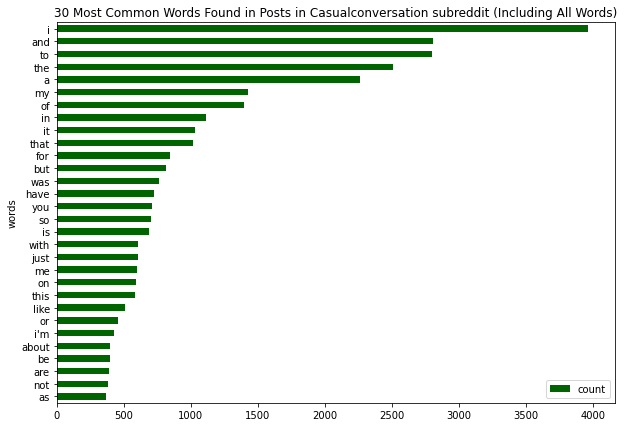

In [25]:
# Establish figure size
fig, ax = plt.subplots(figsize=(10, 7))

# Plot horizontal bar graph 
counts_casualconv_df[:30].sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="darkgreen")
# set title
ax.set_title("30 Most Common Words Found in Posts in Casualconversation subreddit (Including All Words)")
# show plot
plt.show()

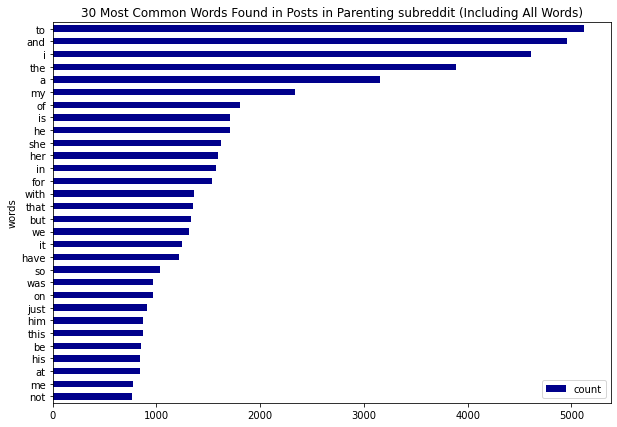

In [26]:
# Establish figure size
fig, ax = plt.subplots(figsize=(10, 7))

# Plot horizontal bar graph 
counts_parenting_df[:30].sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="darkblue")
# set title
ax.set_title("30 Most Common Words Found in Posts in Parenting subreddit (Including All Words)")
# show plot
plt.show()

### Create final stopwords

In [27]:
# Decide to set 0.03% as threshold for stopwords
# anything more than that in the subreddit will be removed
final_stopwords_casualconv = [counts_casualconv_df['words'][i] for i in counts_casualconv_df.index  if counts_casualconv_df['Percentage of total'][i]>0.03]
final_stopwords_parenting = [counts_parenting_df['words'][i] for i in counts_parenting_df.index  if counts_casualconv_df['Percentage of total'][i]>0.03]
print("Selected stopwords for CasualConversation:\n")
print(final_stopwords_casualconv)
print("\nSelected stopwords for Parenting:\n")
print(final_stopwords_parenting)

Selected stopwords for CasualConversation:

['i', 'and', 'to', 'the', 'a', 'my', 'of', 'in', 'it', 'that', 'for', 'but', 'was', 'have', 'you', 'so', 'is', 'with', 'just', 'me', 'on', 'this', 'like', 'or', "i'm", 'about', 'be', 'are', 'not', 'as', 'at', 'if', 'what', 'we', 'do', 'been', 'all', 'they', 'had', 'feel', 'when', 'get', 'really', 'out', 'from', 'how', 'some', 'up', 'i’m', 'know', 'he', 'because', 'would', 'her', 'your', 'people', 'one', 'time', 'can', 'she', "it's", 'an', 'more', 'who', "i've", 'am', "don't", 'them', 'has', 'even', 'think', 'now', 'it.', 'want', 'any', 'only', 'something', 'much', 'other', 'no', 'new', 'got', 'will', 'day', 'good', 'being']

Selected stopwords for Parenting:

['to', 'and', 'i', 'the', 'a', 'my', 'of', 'is', 'he', 'she', 'her', 'in', 'for', 'with', 'that', 'but', 'we', 'it', 'have', 'so', 'was', 'on', 'just', 'him', 'this', 'be', 'his', 'at', 'me', 'not', 'or', 'has', 'like', 'as', 'when', 'do', 'are', 'our', 'all', 'if', 'up', 'what', 'about'

In [28]:
# combine nltk, wordcloud's stopwords and selected stopwords above for each subreddit
stopwords_final = list(set().union(STOPWORDS,stopwords.words('english'),final_stopwords_casualconv,final_stopwords_parenting))
print("There are "+ str(len(stopwords_final)) + " stopwords.\n")
print(stopwords_final)

There are 250 stopwords.

['before', 'its', "he'll", "they've", 'shouldn', 'doing', 'those', "why's", 'by', 'a', 'at', 'below', 'we', 'no', 'up', 'hence', 'wouldn', 'any', 'not', 'them', "i'll", 'aren', 'going', 'wasn', 'y', "here's", "they're", 'over', 'down', 'with', 'under', "mightn't", "can't", 'whom', 'he', "that'll", 've', 'does', "needn't", 'on', "couldn't", 'when', 'don', 'won', 'people', 'cannot', 'weren', 'they', 's', 'time', 'kids', 'themselves', "she's", 'should', 'want', 'otherwise', 'further', 'r', 'itself', 'mustn', 'yours', "don't", 'but', "doesn't", 'for', 'doesn', 'from', 'ours', 'own', 'being', "where's", 'why', 'hers', 'an', 'could', "we'll", 'hadn', 'few', 'it', "when's", 'shan', 'while', 'each', "didn't", 'i’m', "let's", 'of', 'good', 'what', "shouldn't", 'herself', 'off', 'yourselves', 'or', 't', 'can', 'most', "it's", "who's", 'o', 'these', 'ain', 'how', 'so', 'much', "weren't", 'is', 'only', 'feel', 'm', 'his', 'hasn', 'more', "i've", 'one', 'during', 'son', 'i

## Combine into `X` and `y`

In [29]:
# Extract out 'selftext' only
X_casualconv = casualconv[['selftext']] # make into dataframe
y_casualconv = casualconv['subreddit']

X_parenting = parenting[['selftext']]
y_parenting = parenting['subreddit']

In [30]:
# check shape
print(X_casualconv.shape)
print(y_casualconv.shape)
print(X_parenting.shape)
y_parenting.shape

(750, 1)
(750,)
(751, 1)


(751,)

In [31]:
# Display last 5 results
pd.set_option('max_colwidth', 500)
X_casualconv.tail()

,selftext
745,"I am going to start my first job soon, that is, if I manage to graduate this year due to the lockdown. Our country doesn't have a culture of doing jobs while at school. So I'm pretty nervous and was just wondering how your first job experiences were like???"
746,"I had a lot of personality issues. I did not really grow up in a mentally healthy environment, which led me to always look for love. I was always hoping for people to like me. I was kind of a Coward. I never felt like a normal person. During quarantine, I decided to work on myself. I have started to exercise and read. I have also started a journal to write how I feel. The change has begun. I am not going to let my past ruin my future. If there is anyone else with such issues out there; You g..."
747,"Who in your life do you love despite the fact that you have different perspectives?\n\nMy dad and I disagree on just about everything: politics and religion to name a few. \n\nPerhaps it is COVID lockdown that has granted me a new lens of love, acceptance, and tolerance. Perhaps I’ve always just been this way. Who knows? \n\nDespite our differences, I’m always going to love that crusty ol’ asshole. He’s always gonna be my dad and I’m always gonna be his little girl no matter how much the yea..."
748,"Natural yoghurt. Wanted to know my limits. When I was a kid I was a dairy fiend, I'd drink cream if it was there, and milk never lasted long. Yoghurt was a bit more expensive, so when my housemate challenged me I just did what any hero would do. Pretty excited to see what's gonna happen later."
749,"This has been on my mind for a few weeks now and I have not been sure how to put it into words.\n\nWith the large number of people protesting the stay at home orders, it just shows what kind of people we live with. I don't want to single anyone out, but it, to me, looks like the type of people who tell you that you should follow the rules but when it affects them it becomes a problem. I get it, but at the same time, I do not. People are bringing guns to these events and that scares me becaus..."


In [32]:
y_casualconv.tail()

745    CasualConversation
746    CasualConversation
747    CasualConversation
748    CasualConversation
749    CasualConversation
Name: subreddit, dtype: object

In [33]:
X_parenting.tail()

,selftext
746,We plan on attempting our first blanket fort this weekend with our toddler. Any tips? I'm thinking of using our cat tower and the paino since I've our low couch between the two on the wall. I have two european king sheets to use. And I found chip bag clips and I'm still looking for the command strips.
747,"I remember being rebellious when I was a kid, but I never said anything this hurtful to my parents.\n\nWe were arguing over her curfew (it’s 11 PM, I find it reasonable and she doesn’t), and the whole thing escalated until she told me that she’d be happy if I killed myself.\n\nI was shocked when she said it, and I was even more shocked when she showed no remorse. I just walked away, but I went to my bedroom and cried for a while after. I don’t understand. I’ve always had her back and support..."
748,"So, my daughter turned 6 months old yesterday. In celebration, we decided to feed her her very first serving of baby food - peas! She wasn’t sure about them at first, but she caught on fast, and by the time she was finished, she was a huge fan. But, of course, she made a mess - baby food all over her bib and the muslin blanket we were using to try to protect her clothes. No big deal - throw that stuff in the washer with the rest of her clothes. \n\nIT TURNED EVERYTHING YELLOW.\n\nI asked my ..."
749,My daughter is 5 and will be 6 in November. She is my oldest child and I also have a son who will be 4 next month and I am 7 months pregnant with our last child. The problem I am having is it seems like my daughter never left the terrible 2 stage. She is my oldest so I kept saying “oh this must be a phase” but it never went away and I only recently thought that maybe it won’t go away because my 3yo has turned into a mostly respectful child (he makes mistakes occasionally but almost always ap...
750,"Decided it would be smart to get a puppy. I’m not too upset because he’s super cute and good BUT my 20 month old daughter keeps trying to sit on him, lifting her leg up to step on him, purposely rolling around on the ground next to him so the puppy play bites her which causes my daughter to cry, which causes her to need assistance from me only to have her five minutes later go back and antagonize the puppy again. She keeps trying to pick him up which leads to my daughter choke-holding him\n\..."


In [34]:
y_parenting.tail()

746    Parenting
747    Parenting
748    Parenting
749    Parenting
750    Parenting
Name: subreddit, dtype: object

In [35]:
X = pd.concat([X_parenting,X_casualconv])
y = pd.concat([y_parenting,y_casualconv])

In [36]:
print(X.shape)
y.shape

(1501, 1)


(1501,)

In [37]:
X[749:753]

,selftext
749,My daughter is 5 and will be 6 in November. She is my oldest child and I also have a son who will be 4 next month and I am 7 months pregnant with our last child. The problem I am having is it seems like my daughter never left the terrible 2 stage. She is my oldest so I kept saying “oh this must be a phase” but it never went away and I only recently thought that maybe it won’t go away because my 3yo has turned into a mostly respectful child (he makes mistakes occasionally but almost always ap...
750,"Decided it would be smart to get a puppy. I’m not too upset because he’s super cute and good BUT my 20 month old daughter keeps trying to sit on him, lifting her leg up to step on him, purposely rolling around on the ground next to him so the puppy play bites her which causes my daughter to cry, which causes her to need assistance from me only to have her five minutes later go back and antagonize the puppy again. She keeps trying to pick him up which leads to my daughter choke-holding him\n\..."
0,"^(May, 2020)\n\nMonthly Meta is back - [follow the collection](https://www.reddit.com/r/CasualConversation/collection/20266a90-78bb-4216-b643-b4e99aafb4bb) to get notified when a new one is made! This post will be created on the 1st of every month.\n\nWe'd like to keep up-to-date on current thoughts about the subreddit. Here's a few talking points of interest:\n\n* critique or praise the sub\n* critique or praise the mods\n* critique or praise the community\n* address the community\n* ideas ..."
1,Each day this week we'll poll you on how your day is/was going - feel free to submit your vote whenever you think is best.\n\n**Let us know more about your day and chat with us in the comments!**\n\n*Get notified when the next post is live - click follow on the collection.*\n\n[View Poll](https://www.reddit.com/poll/gifijq)


In [38]:
y[749:753]

749             Parenting
750             Parenting
0      CasualConversation
1      CasualConversation
Name: subreddit, dtype: object

In [39]:
y[1495:]

744    CasualConversation
745    CasualConversation
746    CasualConversation
747    CasualConversation
748    CasualConversation
749    CasualConversation
Name: subreddit, dtype: object

In [40]:
# Convert target to 1 and 0
y = y.map({'CasualConversation': 0, 'Parenting':1})

In [41]:
y[749:753]

749    1
750    1
0      0
1      0
Name: subreddit, dtype: int64

In [42]:
y[1498:]

747    0
748    0
749    0
Name: subreddit, dtype: int64

In [43]:
y.value_counts()

1    751
0    750
Name: subreddit, dtype: int64

In [44]:
# Reset index
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

Subreddit Casualconversation and Parenting currently have 749 and 750 posts each respectively.

In [45]:
# Export to csv
pd.DataFrame(X).to_csv('../data/X.csv', index = False)
pd.DataFrame(y).to_csv('../data/y.csv', index = False)

## Split data into training and testing sets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,test_size=0.2) 

In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
y_test.shape

(1200, 1)
(1200,)
(301, 1)


(301,)

In [48]:
y_train.value_counts()

1    600
0    600
Name: subreddit, dtype: int64

In [49]:
y_test.value_counts()

1    151
0    150
Name: subreddit, dtype: int64

## Words Preprocessing

In [50]:
def posts_to_words(subreddit):
    # Function to convert a raw post to a string of words
    # The input is a single string (a raw post of a subreddit), and 
    # the output is a single string (a preprocessed post)
    
    # 1. Remove HTML, if any
    post_text = BeautifulSoup(subreddit).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if w not in stopwords_final]
    
    # 5. Lemmatize words
    # Chose lemmatize over stemming because it's less crude
    # Instantiate lemmatizer. (
    lemmatizer = WordNetLemmatizer()
    short_meaningful_words = [lemmatizer.lemmatize(words) for words in meaningful_words]

    # 6. Join the words back into one string separated by space, 
    # and return the result in order to put into countvectorizer later
    return(" ".join(short_meaningful_words))

In [51]:
# Initialize an empty list to hold the clean posts.
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing posts for training set:")
# For every post in our training set
for posts in tqdm(X_train['selftext']):
    # Convert posts to words, then append to clean_train_posts.
    clean_train_posts.append(posts_to_words(posts))
    
print("Cleaning and parsing posts for training set:")
# For every post in our testingcv set
for posts in tqdm(X_test['selftext']):

    # Convert posts to words, then append to clean_test_posts.
    clean_test_posts.append(posts_to_words(posts))

Cleaning and parsing posts for training set:



Cleaning and parsing posts for training set:


In [52]:
# look at the cleaned train posts
clean_train_posts[:3]

['today watched lady bird realised often living moment trying somewhere future kinda hit hard great movie quite zoned entire life hard live present especially turning adult aspiration supposed come alive im hesitant started working kinda hard others facing issue p sorry bad english',
 'family dog moment mine puppy training parent month month let counted went make sure went month hold till pop rather let back suddenly occurred always order oldest youngest every single taught come get first always way',
 'different parenting style stricter believe child able certain thing flossing teeth able use bathroom without permission supervision try teach child independent feel easier honestly bug actually thing child teaching moment child still young child mother still custody mother everything child tbh involved parent begin play doll make believe child involvement child minuscule babysitter keep child alive child usually screen tv tablet back tv someone give advice better parent spend aware work

In [53]:
# compare with original train posts
X_train.head(3)

,selftext
1352,Today I watched lady bird and realised how so often I haven’t been living in the moment myself. Just trying to be somewhere or something else in the future. It kinda hit me hard. Its a great movie.I have been quite zoned out my entire life and it’s been hard to live in the present especially as I am turning into an adult because that’s when all my aspirations were supposed to come alive. Im very hesitant and I have started working on it. It is kinda hard and I want to know if there are other...
777,"My family has 4 dogs at the moment, 2 are mine, 1 is my son's, and 1 is a puppy we are training for my parents. They are 2 1/2, 1 1/2, 11 months, and 4 months.\n\nI just let them out and counted as they went to make sure they all went out as the 11 month old will hold it till he pops rather than go out. When I let them back in, it suddenly occurred to me that they always go out in the same order\n\n They go out oldest to youngest. \n\nEvery. Single. Time.\n\nThis is something they do on ..."
186,"My SO and I have different parenting styles. I am stricter and believe a child should be able to do certain things on their own such as flossing your teeth, being able to use the bathroom without permission or supervision while my SO tries to teach his child to be independent but just feels it's easier to do it himself. It honestly really bugs me when he actually does things for his child that I feel could be a teaching moment. My SO's child is is still young (5) and the child's mother is st..."


In [54]:
# look at the cleaned test posts
clean_test_posts[:3]

['say someone end life wish said subbed alot sub last moment big change lastimages certain amount word someone gone regret let hear pain',
 'wanted say hello see quarantine stay sane try stay sane least',
 'learning lot need constant activity make happy curious see others learnt strange']

In [55]:
# compare with original test posts
X_test.head(3)

,selftext
886,What would you say to someone who is at the end of their life that you wish you could've said. \n\nI've been subbed to alot of subs that are about the last moments before the big change. Like r/lastimages and so on where you only get a certain amount of words with someone and then it's gone. What are your regrets. Let me hear the pain.
1495,Just wanted to say hello and see how you’re all doing during this quarantine and what you’re doing to stay sane or try to stay sane at least.
1155,I feel like I’m learning a lot about myself during this time ... most of all that I don’t need constant activities to make me happy. I’m curious to see what others have learnt about themselves during this strange time!


## Turn text into features

In [56]:
# Instantiate our CountVectorizer.
cvec = CountVectorizer(max_features=500)

In [57]:
# Fit and transform CountVectorizer on the training data 
# .todense make it to array from sparse matrix
X_train_cvec = pd.DataFrame(cvec.fit_transform(clean_train_posts).todense(),columns=cvec.get_feature_names()) 

In [58]:
X_train_cvec.head()

,able,absolutely,activity,actually,advice,age,ago,almost,alone,along,already,always,amazing,another,answer,anxiety,anymore,anyone,anything,anyway,appreciated,area,around,ask,asked,asking,asleep,attention,awake,away,baby,back,bad,basically,bath,become,bed,bedtime,behavior,behind,believe,best,better,big,birthday,bit,book,bored,born,bottle,...,upset,use,used,using,usually,video,view,virus,visit,voice,wait,wake,walk,want,wanted,watch,watched,watching,water,way,week,weekend,weird,well,went,whatever,whenever,whole,wife,wish,within,without,wondering,word,work,worked,working,world,worried,worry,worse,worth,writing,wrong,year,yesterday,yet,yo,young,yr
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [59]:
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(clean_test_posts).todense(), columns=cvec.get_feature_names())

In [60]:
X_test_cvec.head()

,able,absolutely,activity,actually,advice,age,ago,almost,alone,along,already,always,amazing,another,answer,anxiety,anymore,anyone,anything,anyway,appreciated,area,around,ask,asked,asking,asleep,attention,awake,away,baby,back,bad,basically,bath,become,bed,bedtime,behavior,behind,believe,best,better,big,birthday,bit,book,bored,born,bottle,...,upset,use,used,using,usually,video,view,virus,visit,voice,wait,wake,walk,want,wanted,watch,watched,watching,water,way,week,weekend,weird,well,went,whatever,whenever,whole,wife,wish,within,without,wondering,word,work,worked,working,world,worried,worry,worse,worth,writing,wrong,year,yesterday,yet,yo,young,yr
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Baseline accuracy
We need to calculate baseline accuracy in order to tell if our model is better than null model

In [61]:
y_test.value_counts(normalize=True)
# 50% baseline accuracy 

1    0.501661
0    0.498339
Name: subreddit, dtype: float64

## Fit a Naive Bayes model

In [62]:
# Instantiate our model
nb = MultinomialNB()

In [63]:
# Fit Multinomial Naive Bayes model
model = nb.fit(X_train_cvec,y_train)

In [64]:
# Score our model on the training set via cross validation 10 fold
cross_val_score(nb,X_train_cvec,y_train,cv=10).mean()

0.8466666666666667

In [65]:
# Score our model on the testing set
# This is Accuracy score
nb.score(X_test_cvec,y_test)

0.8604651162790697

In [66]:
# Generate predictions
predictions = nb.predict(X_test_cvec)

In [67]:
# Generate a confusion matrix.
confusion_matrix(y_test,predictions)

array([[121,  29],
       [ 13, 138]])

In [68]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [69]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 121
False Positives: 29
False Negatives: 13
True Positives: 138


In our classification problem, false positive and false negative is equally bad. Hence, looking at accuracy to select our model is better instead of sensitivity or specificity. But is good to see false positive and false negative are not too different from each other.

## Fit a Logistic Regression model

In [70]:
# Instantiate our model
logreg = LogisticRegression()

In [71]:
# Fit Logistic Regression model
logreg.fit(X_train_cvec,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
# Score our model on the training set via cross validation 10 fold
cross_val_score(logreg,X_train_cvec,y_train,cv=10).mean()

0.8275

In [73]:
# Score our model on the testing set
# This is Accuracy score
logreg.score(X_test_cvec,y_test)
# slight underfit
# seems to be a good model

0.867109634551495

## Fit Random Forest Classifier

In [74]:
rf_param = {
    'n_estimators':[200,300,350],
    'max_depth': [None,1,2]
}

In [75]:
rf = GridSearchCV(RandomForestClassifier(),param_grid=rf_param,cv=10)
rf.fit(X_train_cvec,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [76]:
# accuracy value scored against 1/10 of the train data
rf.best_score_

0.8508333333333333

In [77]:
# best hyperparameter for Random Forest
rf.best_params_

{'max_depth': None, 'n_estimators': 350}

In [78]:
# Score model on training set.
rf.score(X_train_cvec, y_train)

0.9991666666666666

In [79]:
# Score model on testing set.
rf.score(X_test_cvec,y_test)
# there is overfit since score dropped

0.8372093023255814

## Compare a few models and get best score

In [80]:
def BestModel(X,y):
    # empty list to store results
    score_list = []
    model_list = []
    test_size_list = []
    vectorizer_list = []
    
    # Set 3 different test size for train_test_split
    x = [0.3,0.25,0.20]
    
    # models to try
    models = [
        MultinomialNB(),
        LogisticRegression(),
        RandomForestClassifier(max_depth=None, n_estimators= 300), #from gridsearchcv result earlier
        ExtraTreesClassifier()
    ]
    
    # vectorizer to try
    vectorizer = [
        CountVectorizer(max_features=500),
        TfidfVectorizer(max_features=500)
    ]
    
    for test_size in x:
        
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,test_size=test_size,random_state=42) 
    
         # Initialize an empty list to hold the clean posts.
        clean_train_posts = []
        clean_test_posts = []

        # For every post in our training set
        for posts in X_train['selftext']:
            # Convert posts to words, then append to clean_train_posts.
            clean_train_posts.append(posts_to_words(posts))
    
        # For every post in our testing set
        for posts in X_test['selftext']:

        # Convert posts to words, then append to clean_test_posts.
            clean_test_posts.append(posts_to_words(posts))
     
        # Instantiate Vectorizer.
        for vectorize in vectorizer:
            
            # Fit and transform Vectorizer on the training data 
            # .todense make it to array from sparse matrix
            X_train_cvec = pd.DataFrame(vectorize.fit_transform(clean_train_posts).todense(),columns=vectorize.get_feature_names()) 
       
            # Transform our testing data with the already-fit Vectorizer.
            X_test_cvec = pd.DataFrame(vectorize.transform(clean_test_posts).todense(), columns=vectorize.get_feature_names())
        
            
            # Fit and score the models
            for model in models:
                model.fit(X_train_cvec, y_train)
                score = model.score(X_test_cvec, y_test)
                # store results
                model_list.append(model)
                score_list.append(score)
                test_size_list.append(test_size)
                vectorizer_list.append(vectorize)
    
    # combine results into dataframe
    df = pd.DataFrame(list(zip(model_list, score_list,test_size_list,vectorizer_list)), 
               columns =['Model', 'Score','Test Size','Vectorizer']) 
    return (df)

In [81]:
# run our BestModel Function
df = BestModel(X,y)
df.head()

,Model,Score,Test Size,Vectorizer
0,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.886918,0.3,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=500, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None,\n strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, vocabulary=None)"
1,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)",0.842572,0.3,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=500, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None,\n strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, vocabulary=None)"
2,"(DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort='deprecated',\n random_state=1607250011, splitter='best'), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=Non...",0.866962,0.3,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=500, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None,\n strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, vocabulary=None)"
3,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, random_state=1958284394,\n splitter='random'), ExtraTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',\n ...",0.858093,0.3,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=500, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None,\n strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, vocabulary=None)"
4,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.880266,0.3,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.float64'>, encoding='utf-8',\n input='content', lowercase=True, max_df=1.0, max_features=500,\n min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,\n smooth_idf=True, stop_words=None, strip_accents=None,\n sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, use_idf=True, vocabulary=None)"


In [82]:
df.sort_values(by='Score',ascending=False)

,Model,Score,Test Size,Vectorizer
21,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)",0.913621,0.20,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.float64'>, encoding='utf-8',\n input='content', lowercase=True, max_df=1.0, max_features=500,\n min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,\n smooth_idf=True, stop_words=None, strip_accents=None,\n sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, use_idf=True, vocabulary=None)"
20,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.910299,0.20,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.float64'>, encoding='utf-8',\n input='content', lowercase=True, max_df=1.0, max_features=500,\n min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,\n smooth_idf=True, stop_words=None, strip_accents=None,\n sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, use_idf=True, vocabulary=None)"
16,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.897010,0.20,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=500, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None,\n strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, vocabulary=None)"
12,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.893617,0.25,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.float64'>, encoding='utf-8',\n input='content', lowercase=True, max_df=1.0, max_features=500,\n min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,\n smooth_idf=True, stop_words=None, strip_accents=None,\n sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, use_idf=True, vocabulary=None)"
13,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)",0.893617,0.25,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.float64'>, encoding='utf-8',\n input='content', lowercase=True, max_df=1.0, max_features=500,\n min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,\n smooth_idf=True, stop_words=None, strip_accents=None,\n sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, use_idf=True, vocabulary=None)"
5,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)",0.889135,0.30,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.float64'>, encoding='utf-8',\n input='content', lowercase=True, max_df=1.0, max_features=500,\n min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,\n smooth_idf=True, stop_words=None, strip_accents=None,\n sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',\n tokenizer=None, use_idf=True, vocabulary=None)"
22,"(DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort='deprecated',\n random_state=1607250011, splitter='best'), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=Non...",0.887043,0.20,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class '

In [83]:
best_model = df.sort_values(by='Score',ascending=False).iloc[0,0]
print(f"The best model is: {best_model}")

The best model is: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [84]:
best_score = df.sort_values(by='Score',ascending=False).iloc[0,1]
print(f"The best score is: {best_score}")

The best score is: 0.9136212624584718


In [85]:
best_test_size = df.sort_values(by='Score',ascending=False).iloc[0,2]
print(f"The best test size ratio is: {best_test_size}")

The best test size ratio is: 0.2


In [86]:
best_vec = df.sort_values(by='Score',ascending=False).iloc[0,3]
print(f"The best vectorizer is: {best_vec}")

The best vectorizer is: TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=500,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


## Fine tuning Logistic Regression hyperparameters

In [87]:
# using test size of 0.2 decided earlier from the BestModel function
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,test_size=0.2,random_state=42) 
    

In [88]:
# Initialize an empty list to hold the clean posts.
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing posts for training set:")
# For every post in our training set
for posts in tqdm(X_train['selftext']):
    # Convert posts to words, then append to clean_train_posts.
    clean_train_posts.append(posts_to_words(posts))
    
print("Cleaning and parsing posts for training set:")
# For every post in our testingcv set
for posts in tqdm(X_test['selftext']):

    # Convert posts to words, then append to clean_test_posts.
    clean_test_posts.append(posts_to_words(posts))
    
# Instantiate the transformer.
tvec = TfidfVectorizer()

# Fit and transform TfidfVectorizer on the training data 
# .todense make it to array from sparse matrix
X_train_tfid = pd.DataFrame(tvec.fit_transform(clean_train_posts).todense(),columns=tvec.get_feature_names()) 
       
# Transform our testing data with the already-fit TfidfVectorizer.
X_test_tfid = pd.DataFrame(tvec.transform(clean_test_posts).todense(), columns=tvec.get_feature_names())
        

Cleaning and parsing posts for training set:



Cleaning and parsing posts for training set:


In [89]:
# parameters for gridsearch
lg_param = {
    'C':[0.1,0.2,0.5,0.8,1]
}

In [90]:
# Instantiate our gridsearchCV
logreg = GridSearchCV(LogisticRegression(random_state=42),param_grid=lg_param,cv=10)

# Fit Logistic Regression model
logreg.fit(X_train_tfid,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.5, 0.8, 1]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [91]:
# accuracy value scored against 1/10 of the train data
logreg.best_score_

0.8658333333333335

In [92]:
# best hyperparameter for Logistic Regression
logreg.best_params_

{'C': 1}

In [93]:
# Score model on training set.
logreg.score(X_train_tfid, y_train)

0.9716666666666667

In [94]:
# Score our model on the testing set
# This is Accuracy score
logreg.score(X_test_tfid,y_test)

0.9069767441860465

## Fit Final Logistic Model

In [95]:
# Instantiate our model
logreg_final = LogisticRegression()

In [96]:
# Fit Logistic Regression model
logreg_final.fit(X_train_tfid,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
# Score our model on the training set via cross validation 10 fold
cross_val_score(logreg_final,X_train_tfid,y_train,cv=10).mean()

0.8658333333333335

In [98]:
# Score our model on the testing set
# This is Accuracy score 
print(f"The best test score is: {round(logreg_final.score(X_test_tfid,y_test),3)*100} %")

The best test score is: 90.7 %


In [99]:
# keep the coefficients in dataframe
coefficients = pd.concat([pd.DataFrame(X_test_tfid.columns),pd.DataFrame(np.transpose(logreg_final.coef_))], axis = 1)
coefficients.columns=['word','coef']
coefficients['exp_coef'] = coefficients['coef'].map(lambda x: math.exp(x))
coefficients.head()

,word,coef,exp_coef
0,aaaaaaaaaa,-0.106863,0.898649
1,aaaaaaaaaaa,-0.026018,0.974317
2,aaalmost,0.082368,1.085856
3,aafb,-0.010274,0.989779
4,ab,0.008557,1.008593


## Conclusion

\begin{eqnarray*}
\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) &=& \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p \\
\Rightarrow e^{\Bigg(\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg)\Bigg)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\Rightarrow \frac{P(Y=1)}{1-P(Y=1)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\end{eqnarray*}

In [100]:
# keep the top 100 features for parenting
coef_parenting = coefficients.sort_values(by='coef',ascending=False)[:100]
coef_parenting.head()

,word,coef,exp_coef
1955,daughter,3.468846,32.099690
1323,child,3.086581,21.902065
592,baby,2.856557,17.401507
8615,wife,2.121921,8.347159
155,advice,1.891412,6.628724


In [101]:
# keep the top 100 features for casualconversation
coef_casualconv = coefficients.sort_values(by='coef',ascending=True)[:100]
coef_casualconv.head()

,word,coef,exp_coef
6297,reddit,-1.399185,0.246798
5646,person,-1.236615,0.290365
5821,poll,-1.208647,0.298601
5173,nice,-1.139317,0.320037
7262,someone,-1.098494,0.333373


Logistic regression is the most common binary classification algorithm. We assume that each independent variable 𝑋𝑖 is linearly related to the log of the odds of success.
To interpret the coefficients, we take the exponential of it. A one-unit change in $X_i$ means that success(classify as parenting) is $e^{\beta_i}$ times as likely.

- As number of 'daughter' word increases by 1, the log-odds of the post coming from 'Parenting' subreddit increases by 3.47.
- As number of 'daughter' word increases by 1, the post coming from 'Parenting' subreddit is about $e^{3.47}$ times = 32.1 times as likely.


In [102]:
# store in dictionary the word and its logit to generate wordcloud 
data_parenting = dict(zip(coef_parenting['word'].tolist(), coef_parenting['exp_coef'].tolist()))
data_casualconv = dict(zip(coef_casualconv['word'].tolist(), coef_casualconv['exp_coef'].tolist()))

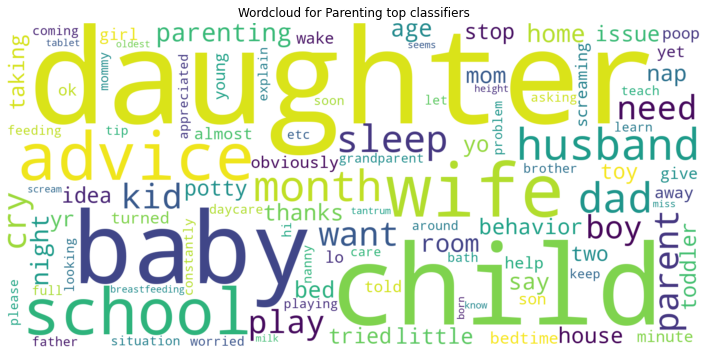

In [103]:
# Generate a wordcloud
wordcloud = WordCloud(width = 1700, height = 800, background_color="white",stopwords='english').generate_from_frequencies(data_parenting)

# Display the generated image
plt.figure(figsize = (13, 6))
# interpolation bilinear makes the wordcloud's text smoother easier to read
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud for Parenting top classifiers")
plt.show()

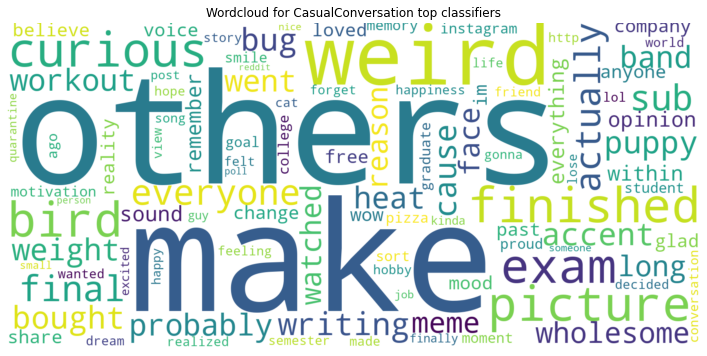

In [104]:
# Generate a wordcloud
wordcloud = WordCloud(width = 1700, height = 800, background_color="white",stopwords='english').generate_from_frequencies(data_casualconv)

# Display the generated image
plt.figure(figsize = (13, 6))
# interpolation bilinear makes the wordcloud's text smoother easier to read
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud for CasualConversation top classifiers")
plt.show()

The wordclouds shows that the words that contributes to parenting subreddit tends to be much more specific to family and parenting related words like daughter,child,baby.
Whereas for casual conversation wordcloud suggest that the theme seems to range widely from exam,weight,weird etc. 

Overall, the best test score is: 90.7% which is better than baseline model of 50%.

## Limitations and Recommendation

The data is collected at fix point in time. Hence, there may be limitations to the model ability to predict future posts and classify them correctly. However, since parenting subreddit inherently surrounds a theme quite well, the predicting ability may not be affected much. 
<br/>
<br/>
Recommendations:
- the data to be collected over a period of time and combined
- more data
- try other models such as KNN
- try n-gram

## Sources
<sup>1</sup> https://www.redditinc.com/ <br/>
<sup>2</sup> https://www.reddit.com/r/CasualConversation<br/>
<sup>3</sup> https://www.reddit.com/r/Parenting/